# Example: Computing Synthetic AR Emission

In [1]:
#import pdb
import os
import subprocess

import dask.distributed
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from solarbextrapolation.example_data_generator import dummyDataToMap

import synthesizAR
import synthesizAR.maps
from synthesizAR.model_ext import UniformHeating, EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeXRT
from synthesizAR.visualize import plot_aia_channels, make_aia_animation

%matplotlib inline

In [2]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:56543 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Simulate Magnetogram
Make a simple dipole magnetogram. Usually would load in an HMI observation

In [3]:
def make_synthetic_map(xrange,yrange,shape,spots):
    delta_x = xrange[1] - xrange[0]
    delta_y = yrange[1] - yrange[0]
    dx = delta_x/arr_grid_shape[0]
    dy = delta_y/arr_grid_shape[1]
    synthetic_hmi_data = np.zeros(arr_grid_shape)
    xphysical,yphysical = np.meshgrid(np.arange(arr_grid_shape[0])*dx,np.arange(arr_grid_shape[1])*dy)
    for spot in spots:
        if spot[0].unit is u.percent:
            pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                              spot[0][1].value/100.*delta_y + yrange[0]])
        else:
            pos = spot[0]
        if spot[1].unit is u.percent:
            sigma = spot[1].value/100.*delta_x
        else:
            sigma = spot[1]
        An_max   = spot[2].value
        An_x     = pos[0]
        An_y     = pos[1]
        An_Dx    = xphysical - An_x + xrange[0]
        An_Dy    = yphysical - An_y + yrange[0]
        An_DxSqu = An_Dx.value**2.0
        An_DySqu = An_Dy.value**2.0
        An_Sigma = sigma.value

        # So this contibution is calculated and added.
        synthetic_hmi_data += An_max * np.exp( - ( (An_DxSqu + An_DySqu) / (2 * An_Sigma**2.0)) )
        
    synthetic_hmi_map = dummyDataToMap(synthetic_hmi_data,xrange,yrange)
    test = Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits')
    for key in ['ctype1','ctype2','rsun_ref','rsun_obs','dsun_ref','dsun_obs',
                'wcsname','crlt_obs','t_obs','date-obs']:
        synthetic_hmi_map.meta[key] = test.meta[key]
        
    return synthetic_hmi_map

In [4]:
arr_grid_shape = [ 300, 300]
xrange = u.Quantity([ -150.0, 150.0 ], u.arcsec)
yrange = u.Quantity([ -150.0, 150.0 ], u.arcsec)
spots = [
    ( u.Quantity([65,50],u.percent), 5*u.percent, -5e3*u.Gauss),
    ( u.Quantity([35,50],u.percent), 5*u.percent,  5e3*u.Gauss)
]
hmi_map = make_synthetic_map(xrange,yrange,arr_grid_shape,spots)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


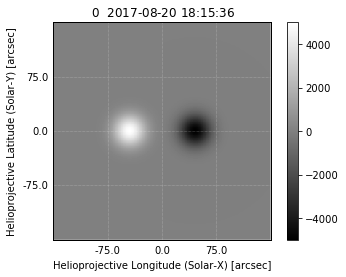

In [5]:
hmi_map.peek()

## Build Magnetic Skeleton
Next, extrapolate a 3D magnetic field from the magnetogram and trace fieldlines through this volume.

In [6]:
field = synthesizAR.Skeleton(hmi_fits_file=hmi_map,resample=u.Quantity([100,100],'pix'))

In [7]:
zrange = u.Quantity([0,300],'arcsec')
zshape = 100

In [8]:
field.extrapolate_field(zshape,zrange)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:81: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-ro

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/Users/willbarnes/anaconda/envs/synthesizar/lib/p

In [9]:
field.extract_streamlines(100,
                          close_threshold=0.05,
                          mask_threshold=0.2,
                          safety=2,
                          loop_length_range=[1e9,2e10]*u.cm)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:64: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:65: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2018-01-23 16:56:24,172 AMRKDTree rebuilt, Final Volume: 9.495799e+30
Streamlining: 100%|██████████| 100/100 [00:00<00:00, 441.07it/s]
yt : [INFO     ] 2018-01-23 16:56:24,758 AMRKDTree rebuilt, Final Volume: 9.495799e+30
Streamlining: 100%|██████████| 36/36 [00:00<00:00, 386.85it/s]
yt : [INFO     ] 2018-01-23 16:56:25,250 AMRKDTree rebuilt, Final Volume: 9.495799e+30
Streamlining:

In [10]:
field.make_loops()

In [11]:
field.loops

[
 Name : loop000000
 Loop full-length, 2L : 47.688 Mm
 Footpoints : (2.29e+09,-1.07e+09,4.38e+08),(-1.75e+09,-1.04e+09,3.93e+08) cm
 Maximum field strength : 42038313.94 G
         , 
 Name : loop000001
 Loop full-length, 2L : 121.407 Mm
 Footpoints : (3.53e+09,5.2e+08,4.38e+08),(-2.95e+09,5.14e+08,3.74e+08) cm
 Maximum field strength : 94101365.68 G
         , 
 Name : loop000002
 Loop full-length, 2L : 41.186 Mm
 Footpoints : (2.11e+09,5.2e+08,4.38e+08),(-1.56e+09,5.17e+08,4.06e+08) cm
 Maximum field strength : 56677926.15 G
         , 
 Name : loop000003
 Loop full-length, 2L : 113.817 Mm
 Footpoints : (3.53e+09,2.11e+09,4.38e+08),(-2.95e+09,2.09e+09,4.21e+08) cm
 Maximum field strength : 41554678.39 G
         , 
 Name : loop000004
 Loop full-length, 2L : 31.431 Mm
 Footpoints : (1.76e+09,1.66e+08,4.38e+08),(-1.19e+09,1.67e+08,4.29e+08) cm
 Maximum field strength : 48049204.55 G
         , 
 Name : loop000005
 Loop full-length, 2L : 88.882 Mm
 Footpoints : (3.18e+09,-1.07e+09,4.38

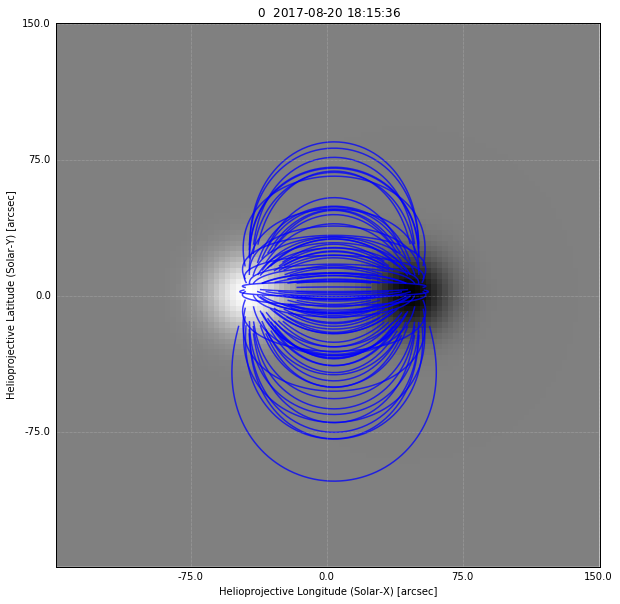

In [12]:
field.peek()

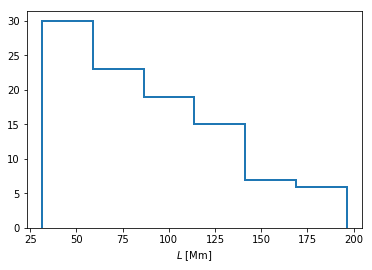

In [13]:
plt.hist([loop.full_length.to(u.Mm).value for loop in field.loops],bins='scott',histtype='step',lw=2);
plt.xlabel(r'$L$ [Mm]')

In [18]:
field.loops[0].full_length.value

4768810906.91201

## Hydrodynamics

In [ ]:
class SingleEventModel(UniformHeating):
    @property
    def number_events(self):
        return 1
heating_options = {'duration':200,'average_waiting_time':1000,'duration_rise':100,
                   'duration_decay':100,'stress_level':1e-6}
heating_model = SingleEventModel(heating_options)

In [ ]:
base_config = synthesizAR.util.InputHandler(
    '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml'
).lookup_vars()
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['force_single_fluid'] = False
base_config['heating']['partition'] = 1.
base_config['heating']['background'] = 1e-6
base_config['turbulent_mean_free_path'] = 1e300

In [ ]:
ebtel_interface = EbtelInterface(base_config,
                                 heating_model,
                                 '/Users/willbarnes/Desktop/simple_example/hydro_config',
                                 '/Users/willbarnes/Desktop/simple_example/hydro_results')

In [ ]:
field.configure_loop_simulations(ebtel_interface)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/Users/willbarnes/Documents/work/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
for loop in field.loops:
    ebtel_runner(loop)

In [ ]:
field.load_loop_simulations(ebtel_interface,savefile='/Users/willbarnes/Desktop/simple_example/loop_parameters.h5')

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops:
    axes[0].plot(loop.time,np.max(loop.electron_temperature.to(u.MK),axis=1),color='C0',alpha=0.1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C1',ls='--',alpha=0.1)
    axes[1].plot(loop.time,np.mean(loop.density,axis=1)/1e9,color='C0',alpha=0.25)
#axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylim([0,20])
axes[1].set_ylim([0,30])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [ ]:
field.save('/Users/willbarnes/Desktop/simple_example/field_checkpoint')

In [2]:
field = synthesizAR.Skeleton.restore('/Users/willbarnes/Desktop/simple_example/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi

In [3]:
field.hmi_map.meta

MetaDict([('simple', True),
          ('bitpix', -64),
          ('naxis', 2),
          ('naxis1', 100),
          ('naxis2', 100),
          ('t_obs', '2017.08.20_18:16:36_TAI'),
          ('bunit', 'Tesla'),
          ('cdelt1', 3.0),
          ('cdelt2', 3.0),
          ('cunit1', 'arcsec'),
          ('cunit2', 'arcsec'),
          ('crpix1', 50.5),
          ('crpix2', 50.5),
          ('rsun_ref', 696000000),
          ('dsun_ref', 149597870691),
          ('datamax', 4999.999923850101),
          ('datamin', -4999.999923850101),
          ('datavals', 90000),
          ('crval1', 0.500000000014277),
          ('crval2', 0.5000000000380571),
          ('ctype1', 'HPLN-TAN'),
          ('ctype2', 'HPLT-TAN'),
          ('rsun_obs', 948.762512),
          ('dsun_obs', 151313748757.22),
          ('wcsname', 'Helioprojective-cartesian'),
          ('crlt_obs', 6.887226),
          ('date-obs', '2017-08-20T18:15:36.20'),
          ('pc1_1', 1.0),
          ('pc1_2', 0.0),
          

## Forward Modeling

In [ ]:
aia = InstrumentSDOAIA([0,5000]*u.s, use_temperature_response_functions=True)

In [ ]:
xrt = InstrumentHinodeXRT([0, 5000]*u.s)

In [ ]:
observer = synthesizAR.Observer(field,[xrt],parallel=True)

In [ ]:
observer.build_detector_files('/Users/willbarnes/Desktop/simple_example/',
                              ds=field._convert_angle_to_length(0.3*u.arcsec))

In [ ]:
tasks = observer.flatten_detector_counts()

In [ ]:
tasks['Hinode_XRT_parameters'].compute()

In [ ]:
tasks['Hinode_XRT_counts'].compute()

In [ ]:
tasks['SDO_AIA_parameters'].compute()

In [ ]:
tasks['SDO_AIA_counts'].compute()

Only want to build 100 maps so rebuild the detector object

In [ ]:
aia = InstrumentSDOAIA([1000,1100]*u.s, use_temperature_response_functions=True)

In [4]:
xrt = InstrumentHinodeXRT([1000,2000]*u.s)

In [5]:
observer = synthesizAR.Observer(field,[xrt],parallel=True)

In [6]:
observer.build_detector_files('/Users/willbarnes/Desktop/simple_example/',
                              ds=field._convert_angle_to_length(0.3*u.arcsec))

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev543-py3.6.egg/synthesizAR/instruments/base.py:117: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_x = np.fabs(field.clipped_hmi_map.xrange[1] - field.clipped_hmi_map.xrange[0])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev543-py3.6.egg/synthesizAR/instruments/base.py:118: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_y = np.fabs(field.clipped_hmi_map.yrange[1] - field.clipped_hmi_map.yrange[0])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-pac

In [7]:
tasks = observer.bin_detector_counts('/Users/willbarnes/Desktop/simple_example/')

In [8]:
jobs = client.compute(tasks['Hinode_XRT'])

In [ ]:
jobs[0].result()

In [ ]:
jobs=None

## Visualize

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:774: Warning: Unknown value for WAVEUNIT
  Warning)


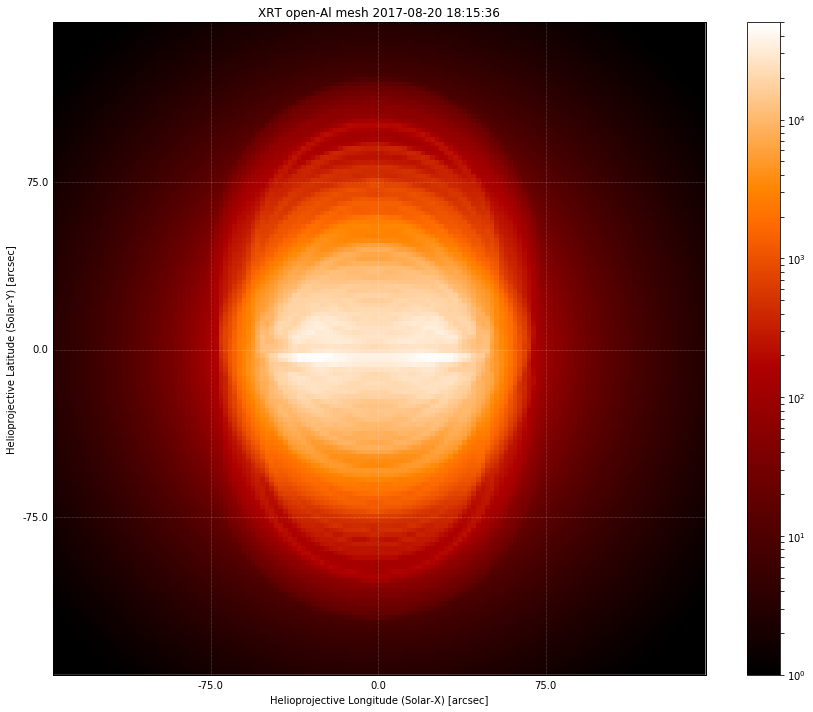

In [25]:
fig = plt.figure(figsize=(15,12))
tmp = Map(f'/Users/willbarnes/Desktop/simple_example/Hinode_XRT/open-Al_mesh/map_t000050.fits')
ax = fig.add_subplot(111,projection=tmp)
tmp.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1,vmax=5e4))
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(10,10))
tmp = Map(f'/Users/willbarnes/Desktop/simple_example/SDO_AIA/94/map_t000241.fits')
ax = fig.add_subplot(111,projection=tmp)
tmp.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1e-1,vmax=5e3))

In [ ]:
fig = plt.figure(figsize=(10,10))
tmp = Map(f'/Users/willbarnes/Desktop/simple_example/SDO_AIA/131/map_t000242.fits')
ax = fig.add_subplot(111,projection=tmp)
tmp.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1e-1,vmax=5e3))

In [ ]:
fig = plt.figure(figsize=(10,10))
tmp = Map(f'/Users/willbarnes/Desktop/simple_example/SDO_AIA/171/map_t000243.fits')
ax = fig.add_subplot(111,projection=tmp)
tmp.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1e-1,vmax=5e3))

In [ ]:
fig = plt.figure(figsize=(10,10))
tmp = Map(f'/Users/willbarnes/Desktop/simple_example/SDO_AIA/193/map_t000248.fits')
ax = fig.add_subplot(111,projection=tmp)
tmp.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1e-1,vmax=5e3))

In [ ]:
fig = plt.figure(figsize=(10,10))
tmp = Map(f'/Users/willbarnes/Desktop/simple_example/SDO_AIA/211/map_t000255.fits')
ax = fig.add_subplot(111,projection=tmp)
tmp.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1e-1,vmax=5e3))

In [ ]:
fig = plt.figure(figsize=(10,10))
tmp = Map(f'/Users/willbarnes/Desktop/simple_example/SDO_AIA/335/map_t000248.fits')
ax = fig.add_subplot(111,projection=tmp)
tmp.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1e-1,vmax=5e3))

In [ ]:
plot_aia_channels(aia,1000*u.s,'/Users/willbarnes/Desktop/simple_example/')

In [ ]:
ani = make_aia_animation(aia,1000*u.s,1100*u.s,'/Users/willbarnes/Desktop/simple_example/')

In [ ]:
ani.save('/Users/willbarnes/Desktop/sample_mov.mp4')